# Open Exploration (PF1)
---

This notebook is used to conduct Open Exploration using Problem Formulation 1, the Top-down National perspective with a spatial aggregation of outcomes

<!-- Table of Content -->
### Table of Content
- Importing Libraries
- Run Model
- Global Sensitivity Analysis
- Scenario Discovery

---
### Importing Libraries

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools

# EMA
from ema_workbench import (Scenario, Policy, MultiprocessingEvaluator, perform_experiments, ema_logging)
from ema_workbench import Samplers
from ema_workbench import save_results, load_results
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

# Analytical Tools
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

# Model
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

### 0 Run Model
We ran Sobol Sampling for (0a) Policy Space and (0b) Uncertainty Space which will be used in sensitivity analysis and scenario discovery.

- (0a) Policy Space will run on the Ref Scenario and 256 Policies 
- (0b) Uncertainty Space will run on the Ref Policy and 5000 Scenarios

#### (0a) Sobol Sample Policy Space

In [2]:
%%script false --no-raise-error

# Model Settings
pf = 1
s = 1
p = 256

#------------------------- Initialize Model
model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

#------------------------- Reference Scenario
ref_val = {'Bmax': 175, 
           'Brate': 1.5, 
           'pfail': 0.5,
            'discount rate 0': 3.5,
            'ID flood wave shape': 4}
ref_dict = {}
# < ref_dict >
# reference scenario updated for all dike rings
for key in model.uncertainties:
    name_split = key.name.split('_')
    if len(name_split) == 1:
        if key.name in ref_val.keys():
            ref_dict.update({key.name: ref_val[key.name]})
    else:
        ref_dict.update({key.name: ref_val[name_split[1]]})

ref_scenario = Scenario('reference', **ref_dict)

#------------------------- Run Model
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(model, n_processes=7) as evaluator:
    results = evaluator.perform_experiments(scenarios=ref_scenario, policies=p, lever_sampling=Samplers.SOBOL)

save_results(results, 'results/data/GSA_PF{}_S{}_P{}_.tar.gz'.format(pf,s,p))

Couldn't find program: 'false'


#### (0b) Sobol Sample Scenario Space

In [3]:
%%script false --no-raise-error

# Model Settings
pf = 1
s = 5000
p = 1

#------------------------- Initialize Model
model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

#------------------------- Reference Policy
ref_policy = [Policy('policy 1', **{'0_RfR 0':0,
                                    '1_RfR 0':0,
                                    '2_RfR 0':0,
                                    '3_RfR 0':0,
                                    '4_RfR 0':0,
                                  'A.1_DikeIncrease 0':0,
                                  'A.2_DikeIncrease 0':0,
                                  'A.3_DikeIncrease 0':0,
                                  'A.4_DikeIncrease 0':0,
                                  'A.5_DikeIncrease 0':0,
                                  'EWS_DaysToThreat':0})
                                  ]

#------------------------- Run Model
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(model, n_processes=7) as evaluator:
    results = evaluator.perform_experiments(scenarios=s, policies=ref_policy, lever_sampling=Samplers.SOBOL)

save_results(results, 'results/GSA_PF{}_S{}_P{}_.tar.gz'.format(pf,s,p))

Couldn't find program: 'false'


In [4]:
# Function used to flatten Sobol S2 Dictionary Output

def flatten_dict_arrays(dictionary):
    flattened_dict = {}

    for key, value in dictionary.items():
        flattened_array = []
        for row in value:
            flattened_array.extend(row)
        flattened_dict[key] = flattened_array

    return flattened_dict

### 1 Global Sensivity Analysis
- (1a) Sobol Analysis was used to understand how outcomes are primarily linked to policies through direct and indirect effects
    - (1a1) Outcome of focus: Expected Number of Deaths
    - (1a2) Outcome of focus: Expected Annual Damage
- (1b) Feature Scoring was used to have a summarized overview on how outcomes are linked to inputs
    - (1b1) Focused on Uncertainty Space 
    - (1b2) Focused on Policy Space (to validate 1a's findings)

#### (1a) Sobol Analysis (Policy Space)

In [5]:
# Model Settings

# Sampling policy
pf, s, p = 1, 1, 256 

results = load_results('results/data/GSA_PF{}_S{}_P{}_.tar.gz'.format(pf,s,p))
experiments, outcomes = results

model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

[MainProcess/INFO] results loaded successfully from c:\Users\ryant\Google Drive\School (TUD)\Semester 4\4_Model-based Decision-making\model-based-decision-making\final_assignment\results\data\GSA_PF1_S1_P256_.tar.gz


##### (1a1) Expected Number of Deaths

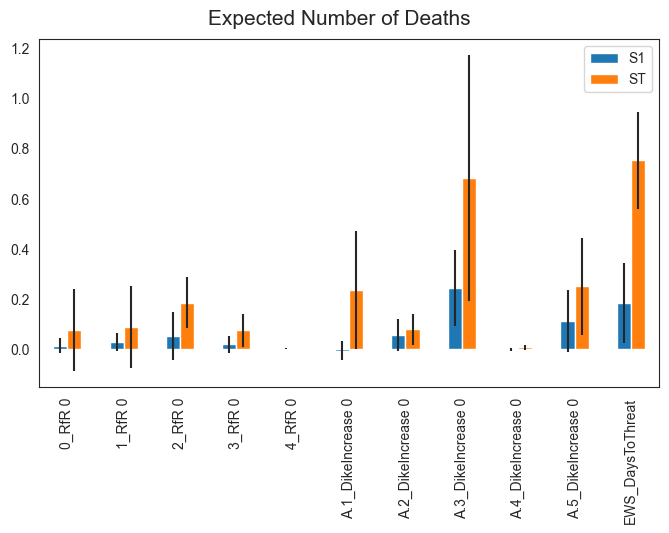

In [6]:
# Prepare Sobol Variables
problem = get_SALib_problem(levers)
outcome_var = 'Expected Number of Deaths'
Si = sobol.analyze(problem, outcomes[outcome_var], print_to_console=False)

# Process Dataframe: Filter S1+ST
Si_filter_s1_st = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter_s1_st, index= problem['names'])

# Visualize Sobol indices
sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.suptitle(outcome_var, fontsize=15, y=0.93)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)

plt.show()

Graph of expected number of deaths (S1,ST)
- (Direct Effects) A3 Dike Increase has the greatest direct influence on the spatially aggregated Annual Deaths
- (Total Order Effects) Total Effects have a much greater influence than Direct Effects. A3 Dike and EWS contribute the most.

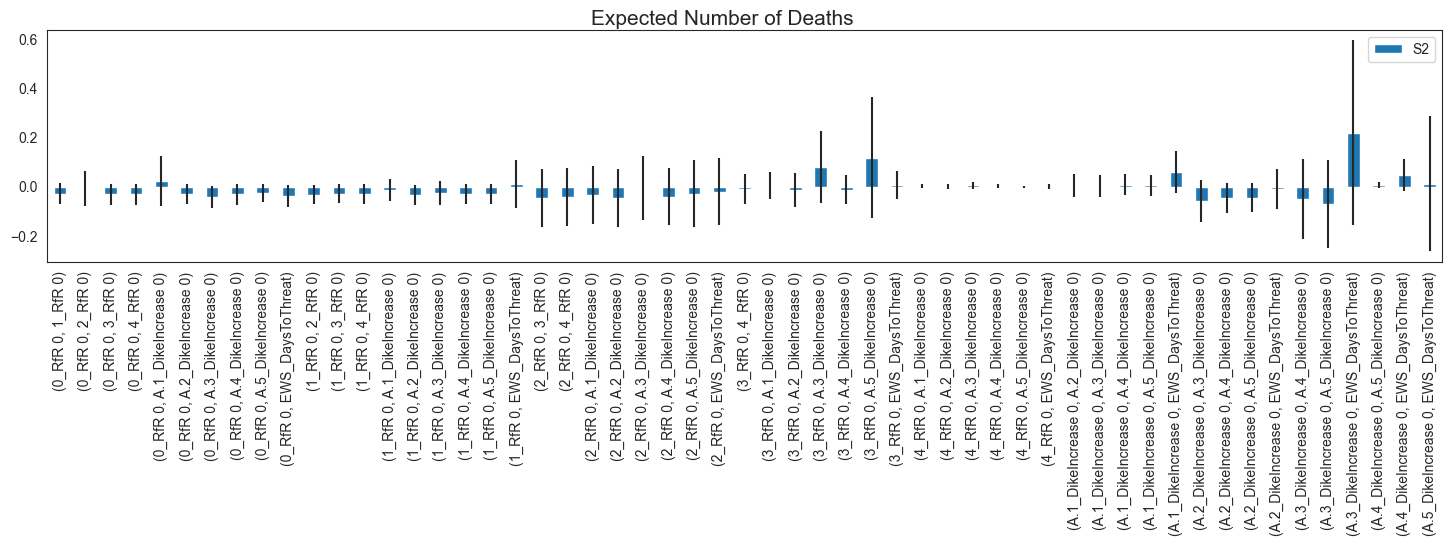

In [7]:
# Process Dataframe: Filter S2


Si_filter_s2 = {k:Si[k] for k in ['S2','S2_conf']}
S2_df = pd.DataFrame(flatten_dict_arrays(Si_filter_s2), index= list(itertools.product(problem['names'], repeat=2)))

# Visualize Sobol indices
sns.set_style('white')
fig, ax = plt.subplots(1)

indices, err = S2_df[["S2"]].dropna(), S2_df[['S2_conf']].dropna()

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.suptitle(outcome_var, fontsize=15, y=0.93)
fig.set_size_inches(18,4)
fig.subplots_adjust(bottom=0.3)
plt.show()

Graph of expected annual deaths (S2)
- (Order of Effects)
- A3 Dike + EWS
- A5 Dike + 3_RFR
- A3 Dike + 3_RFR 

##### (1a2) Expected Annual Damage

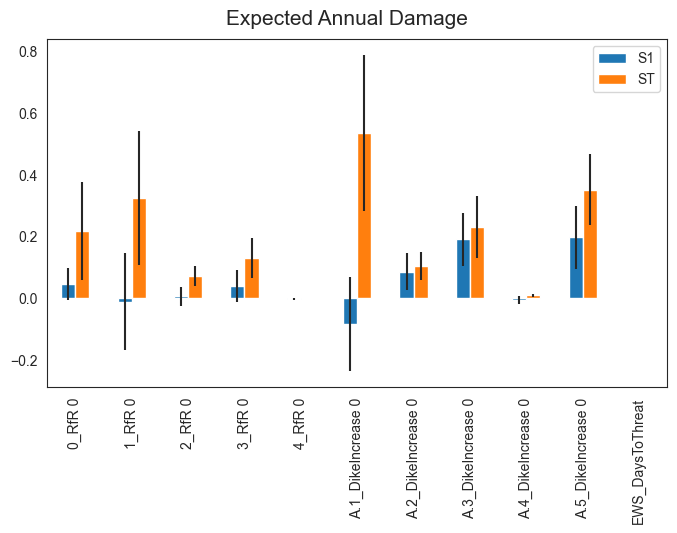

In [8]:
# Prepare Sobol Variables
problem = get_SALib_problem(levers)
outcome_var = 'Expected Annual Damage'
Si = sobol.analyze(problem, outcomes[outcome_var], print_to_console=False)

# Process Dataframe: Filter S1+ST
Si_filter_s1_st = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter_s1_st, index= problem['names'])

# Visualize Sobol indices
sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.suptitle(outcome_var, fontsize=15, y=0.93)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

Graph of expected annual damage (S1,ST)
- (Direct Effects) **A3 and A5 Dike** Increase has the greatest direct influence on the spatially aggregated Annual Damage
- (Total Order Effects) Total Effects have a much greater influence than Direct Effects. **A1 Dike and A5 Dike and 0_RFR 1_RFR** contribute the most.

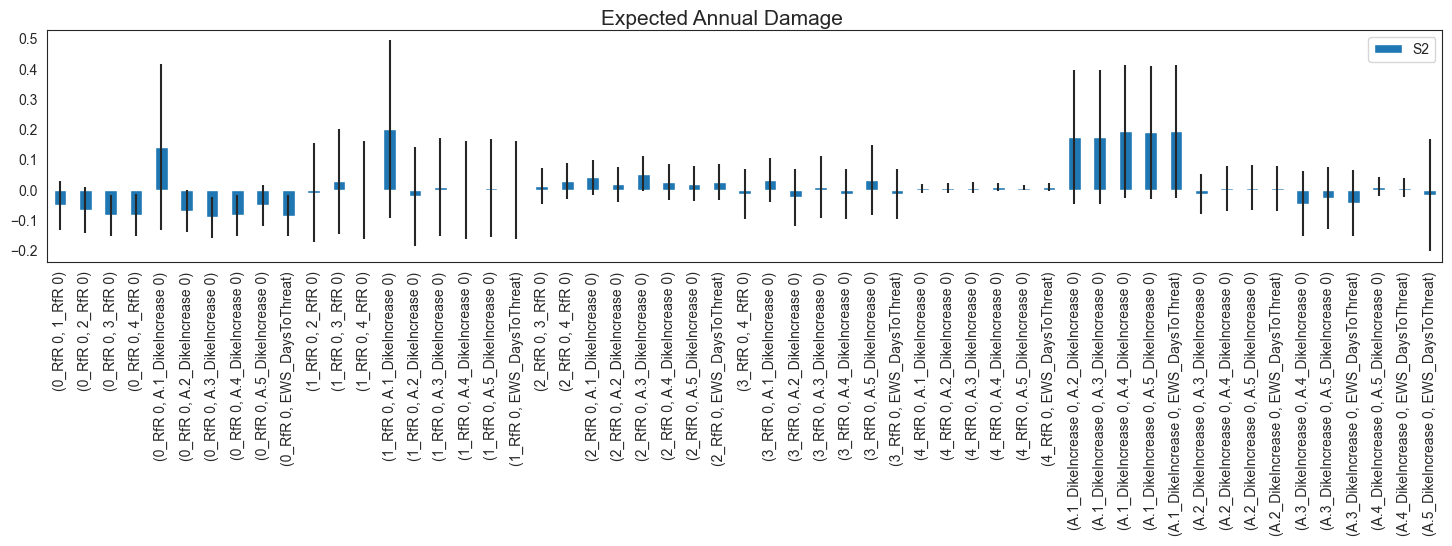

In [9]:
# Process Dataframe: Filter S2
Si_filter_s2 = {k:Si[k] for k in ['S2','S2_conf']}
S2_df = pd.DataFrame(flatten_dict_arrays(Si_filter_s2), index= list(itertools.product(problem['names'], repeat=2)))

# Visualize Sobol indices
sns.set_style('white')
fig, ax = plt.subplots(1)

indices, err = S2_df[["S2"]].dropna(), S2_df[['S2_conf']].dropna()

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.suptitle(outcome_var, fontsize=15, y=0.93)
fig.set_size_inches(18,4)
fig.subplots_adjust(bottom=0.3)
plt.show()

Graph of expected annual damage (S2)
- (2nd Order Effects) 
- A1 Dike with any combination of other dikes, 
- A1 Dike with 1_RFR
- A1 Dike with 0_RFR

#### (1b) Feature Scoring

##### (1b1) Feature Scoring (Uncertainty Space)

In [10]:
#sampling scenario
pf, s, p = 1, 5000, 1 

results = load_results('results/data/GSA_PF{}_S{}_P{}_.tar.gz'.format(pf,s,p))
experiments, outcomes = results
# drop uncertainties
experiments.drop(columns=list(model.levers.keys()), inplace=True)

model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

[MainProcess/INFO] results loaded successfully from c:\Users\ryant\Google Drive\School (TUD)\Semester 4\4_Model-based Decision-making\model-based-decision-making\final_assignment\results\data\GSA_PF1_S5000_P1_.tar.gz


[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


<Axes: ylabel='0'>

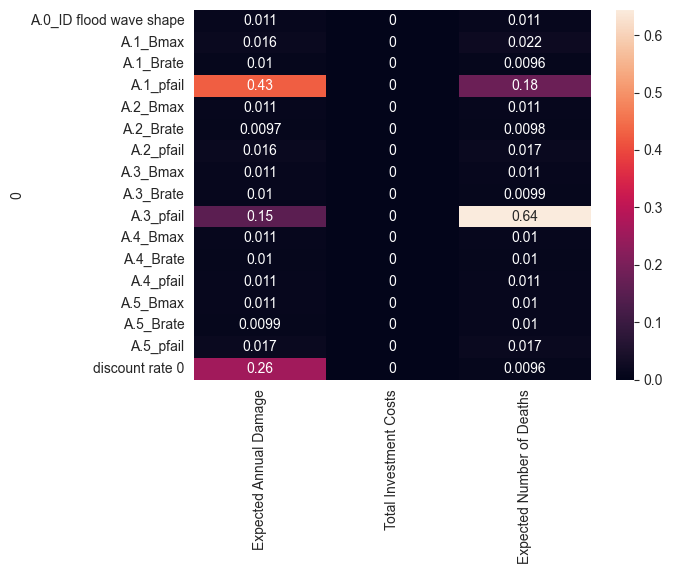

In [11]:
scores = feature_scoring.get_feature_scores_all(experiments, outcomes, mode=RuleInductionType.REGRESSION)
sns.heatmap(scores, annot=True)

Feature score of uncertainties
- Expected Annual Damage is driven by A1_pfail, discount rate 0, A3_pfail
- Expected Number of Deaths is driven by A3_pfail and A1_pfail

##### (1b2) Feature Scoring (Sample Policy Space)

In [12]:
#sampling scenario
pf, s, p = 1, 1, 256 

results = load_results('results/data/GSA_PF{}_S{}_P{}_.tar.gz'.format(pf,s,p))
experiments, outcomes = results
# drop policies
experiments.drop(columns=list(model.uncertainties.keys())+['policy'], inplace=True)

model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

[MainProcess/INFO] results loaded successfully from c:\Users\ryant\Google Drive\School (TUD)\Semester 4\4_Model-based Decision-making\model-based-decision-making\final_assignment\results\data\GSA_PF1_S1_P256_.tar.gz


[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


<Axes: ylabel='0'>

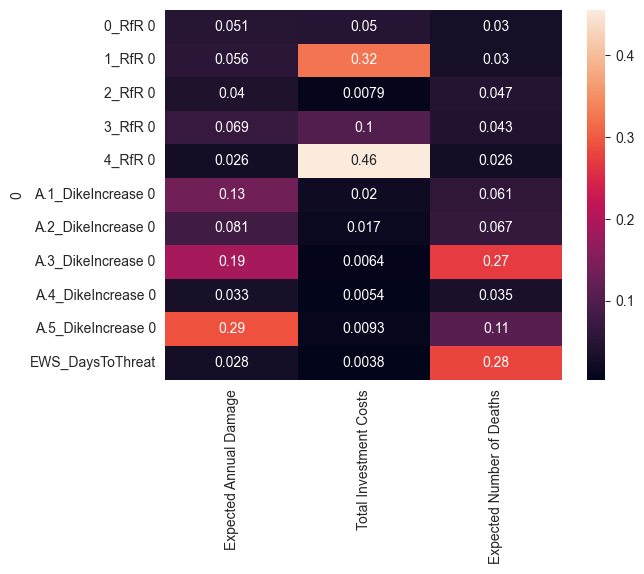

In [13]:
scores = feature_scoring.get_feature_scores_all(experiments, outcomes, mode=RuleInductionType.REGRESSION)
sns.heatmap(scores, annot=True)

Feature score of policies
- Expected Annual Damage is driven by Dikes - A5, A3, A1
- Total Investment Costs is driven by RFR - 4, 1, 3
- Expected Number of Deaths is driven by Dikes - A5, A3, EWS

### 2 Scenario Discovery (PRIM on Uncertainties)
PRIM was conducted to understand the uncertainty space in which the most undesirable outcomes:

- (2a) Expected Number of Deaths
- (2b) Expected Annual Damages

##### (2a) Expected Number of Deaths

In [14]:
from ema_workbench.analysis import prim

In [15]:
#sampling scenario
pf, s, p = 1, 5000, 1 

results = load_results('results/data/GSA_PF{}_S{}_P{}_.tar.gz'.format(pf,s,p))
experiments, outcomes = results
# drop uncertainties
experiments.drop(columns=list(model.levers.keys()), inplace=True)

model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

[MainProcess/INFO] results loaded successfully from c:\Users\ryant\Google Drive\School (TUD)\Semester 4\4_Model-based Decision-making\model-based-decision-making\final_assignment\results\data\GSA_PF1_S5000_P1_.tar.gz


In [16]:
# Set value range
outcome_var = 'Expected Number of Deaths'

# Set quantile or actual values
max_value = np.quantile(outcomes[outcome_var], 0.8)
min_value = np.quantile(outcomes[outcome_var], 0.2)
logical = np.array([value > max_value for value in outcomes[outcome_var]])

# define prim input parameters
x = experiments
y = logical

# run prim algorithm to find box
prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.1)
box1 = prim_alg.find_box()

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 5000 points remaining, containing 1000 cases of interest


[MainProcess/INFO] mean: 1.0, mass: 0.0884, coverage: 0.442, density: 1.0 restricted_dimensions: 5


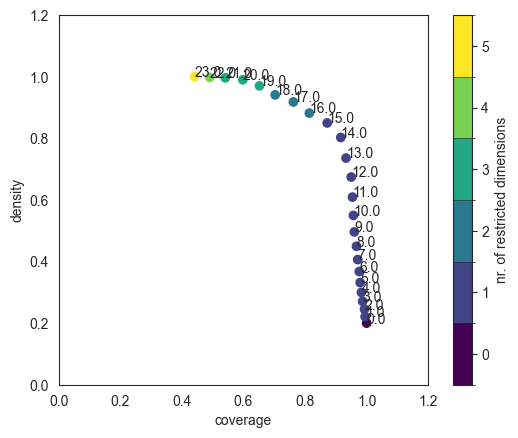

In [17]:
import matplotlib.pyplot as plt
 
box1.show_tradeoff(annotated=True)
plt.show()

coverage     0.872000
density      0.849903
id          15.000000
mass         0.205200
mean         0.849903
res_dim      1.000000
Name: 15, dtype: float64

             box 15                            
                min       max qp value qp value
A.3_pfail  0.000052  0.205227      NaN      0.0



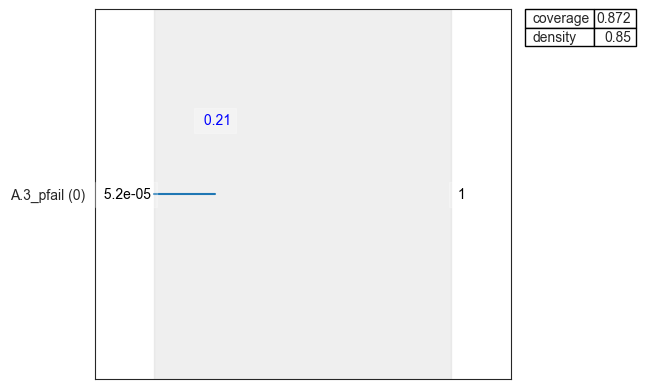

In [18]:
to_inspect = 15

box1.inspect(to_inspect)
box1.inspect(to_inspect, style='graph')
plt.show()

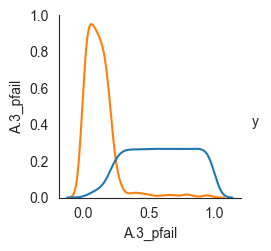

In [19]:
box1.select(to_inspect)
fig = box1.show_pairs_scatter()
plt.show()

- Results where Number of Deaths is at the 80% percentile is when A3_pfail is below 0.21

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


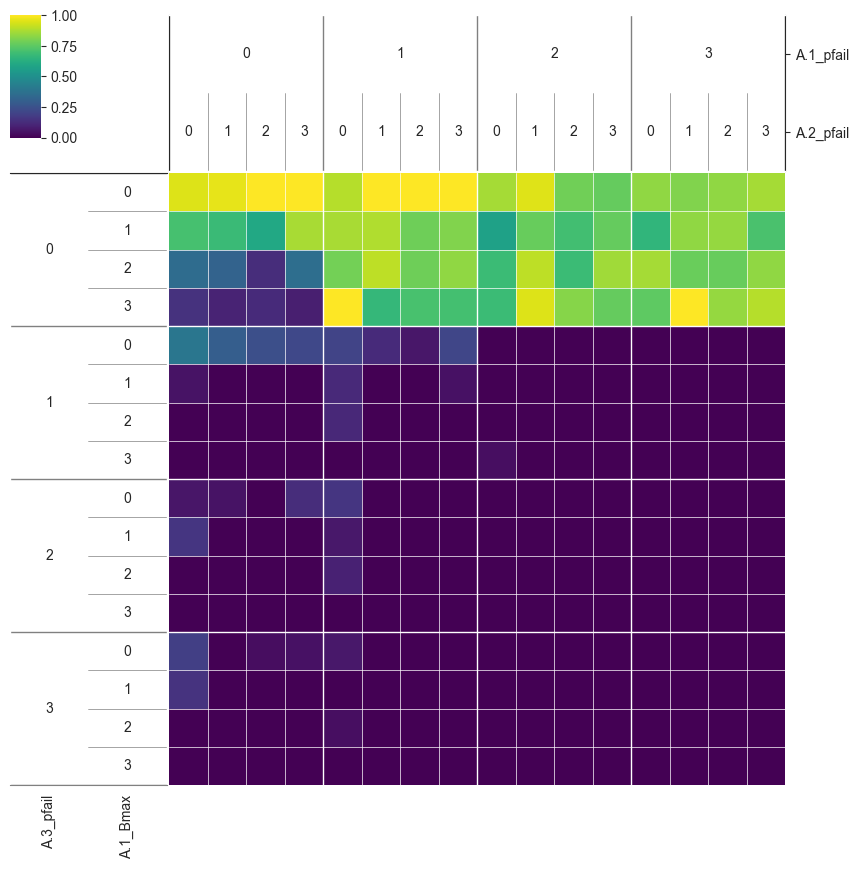

In [20]:
# Do dimensional stacking of results
from ema_workbench.analysis import dimensional_stacking

dimensional_stacking.create_pivot_plot(x, y, 2, nbins=4)
plt.show()

##### (2b) Expected Damages

In [21]:
# Set value range
outcome_var = 'Expected Annual Damage'

# Set quantile or actual values
max_value = np.quantile(outcomes[outcome_var], 0.8)
min_value = np.quantile(outcomes[outcome_var], 0.2)
logical = np.array([value > max_value for value in outcomes[outcome_var]])

# define prim input parameters
x = experiments
y = logical

# run prim algorithm to find box
prim_alg = prim.Prim(x, y, threshold=0.15, peel_alpha=0.1)
box1 = prim_alg.find_box()

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 5000 points remaining, containing 1000 cases of interest


[MainProcess/INFO] mean: 1.0, mass: 0.083, coverage: 0.415, density: 1.0 restricted_dimensions: 2


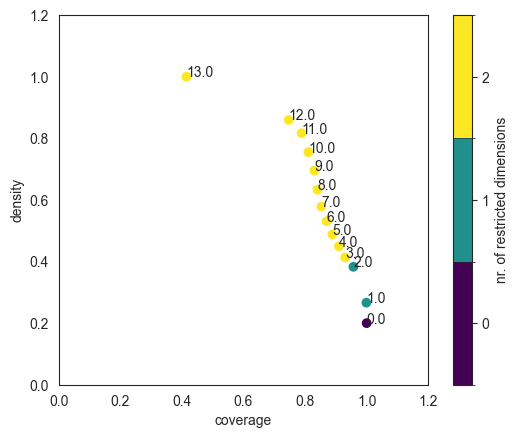

In [22]:
import matplotlib.pyplot as plt
 
box1.show_tradeoff(annotated=True)
plt.show()

There is no clear box where uncertainties influences damage